# FINAL PROJECT : STATS 202
Outcome to evaluate is ability of the model to predict the security prices up to 9 days into the future. 
Specifically, you will need to predict the 'open' prices for the 9 days following the end of the training data.

# Preprocessing & Transformation

In [111]:
# Import Libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
interval = 5
int_permin = 60 / interval
int_perhr = int_permin * 60
int_perday = int_perhr * 7
# total_int = int_perday * 87
# total_sec = total_int * 5

print(int_permin, int_perhr, int_perday) #, total_int, total_sec)

In [4]:
# Read data
data = pd.read_csv('train_data.csv')
data.drop('time',axis=1, inplace=True) # Drop time predictor for simplicity
data.head()

,symbol,open,high,low,close,average,day
0,B,101.72,101.72,101.72,101.72,101.72,0
1,B,101.72,101.72,101.72,101.72,101.72,0
2,B,101.72,101.72,101.72,101.72,101.72,0
3,B,101.72,101.72,101.72,101.72,101.72,0
4,B,101.72,101.72,101.72,101.72,101.72,0


In [5]:
# Compute additional variables

"""
Spread 
------ 
Difference between high and low values during a trading period.
"""
data["spread"] = data["high"] - data["low"]

"""
Percent Change
--------------
Represents the change in trading price within a trading period (open to close), in percentage
"""
data["p_change"] = (data["close"] - data["open"]) / data["close"] * 100

print(data)

        symbol    open    high     low   close  average  day  spread  p_change
0            B  101.72  101.72  101.72  101.72   101.72    0    0.00  0.000000
1            B  101.72  101.72  101.72  101.72   101.72    0    0.00  0.000000
2            B  101.72  101.72  101.72  101.72   101.72    0    0.00  0.000000
3            B  101.72  101.72  101.72  101.72   101.72    0    0.00  0.000000
4            B  101.72  101.72  101.72  101.72   101.72    0    0.00  0.000000
...        ...     ...     ...     ...     ...      ...  ...     ...       ...
4330249      H   78.26   78.29   78.25   78.29    78.28   86    0.04  0.038319
4330250      H   78.28   78.29   78.28   78.29    78.28   86    0.01  0.012773
4330251      H   78.29   78.30   78.28   78.30    78.29   86    0.02  0.012771
4330252      H   78.29   78.30   78.26   78.26    78.29   86    0.04 -0.038334
4330253      H   78.28   78.29   78.25   78.26    78.27   86    0.04 -0.025556

[4330254 rows x 9 columns]


In [6]:
# Split data by symbols and store in list
# Symbol: A B C D E F G H I J
symbols = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J')
stocks = (data.loc[data['symbol'] == 'A'], data.loc[data['symbol'] == 'B'], data.loc[data['symbol'] == 'C'], data.loc[data['symbol'] == 'D'], data.loc[data['symbol'] == 'E'], data.loc[data['symbol'] == 'F'], data.loc[data['symbol'] == 'G'], data.loc[data['symbol'] == 'H'], data.loc[data['symbol'] == 'I'], data.loc[data['symbol'] == 'J'])

In [7]:
# Print shape of each symbol
for i in range (len(symbols)):
    print('The shape of symbol', symbols[i], 'is:', stocks[i].shape)

The shape of symbol A is: (426897, 9)
The shape of symbol B is: (427909, 9)
The shape of symbol C is: (438480, 9)
The shape of symbol D is: (437040, 9)
The shape of symbol E is: (438229, 9)
The shape of symbol F is: (412631, 9)
The shape of symbol G is: (436946, 9)
The shape of symbol H is: (437760, 9)
The shape of symbol I is: (437040, 9)
The shape of symbol J is: (437322, 9)


Text(0, 0.5, 'p_change price USD ($)')

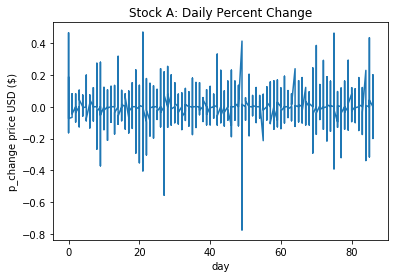

In [8]:
# Plot Stock A

var = 'p_change' #set desired variable to plot

plt.plot(stocks[0]['day'], stocks[0][var])
plt.title('Stock A: Daily Percent Change')
plt.xlabel('day')
label_for_y = var + ' price USD ($)'
plt.ylabel(label_for_y)

In [ ]:
plt.plot(stocks[0]['day'], stocks[0]['open'])
plt.xlabel('day')
plt.ylabel('open price USD ($)')

/Users/pascualcamacho/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/pascualcamacho/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


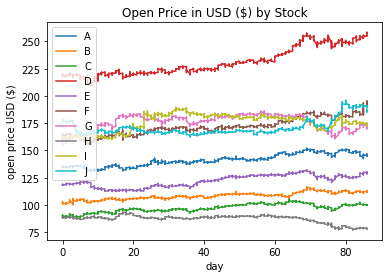

In [10]:
# Overview of Open Price, by day

var = 'open' # set desired variable to plot

for i in range(len(symbols)):
    label = symbols[i]
    plt.plot(stocks[i]['day'], stocks[i][var], label=label)
plt.title('Open Price in USD ($) by Stock')
plt.xlabel('day')
label_upd = var + ' price USD ($)'
plt.ylabel(label_upd)
plt.legend()

# Data Mining — Linear Regression

In [11]:
# Split data 
"""
Starting with STOCK A for simplicity (index = 0).

Split
-----
Train set: 75% of data
Test set: 25% of data
-Cross-validation: 10% of data
"""
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Read data
data = pd.read_csv('train_data.csv')
data.drop('time',axis=1, inplace=True) # Drop time predictor for simplicity
data['symbol'] = data['symbol'].map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9}) # Convert symbols to numbers using map
data

,symbol,open,high,low,close,average,day
0,1,101.72,101.72,101.72,101.72,101.72,0
1,1,101.72,101.72,101.72,101.72,101.72,0
2,1,101.72,101.72,101.72,101.72,101.72,0
3,1,101.72,101.72,101.72,101.72,101.72,0
4,1,101.72,101.72,101.72,101.72,101.72,0
...,...,...,...,...,...,...,...
4330249,7,78.26,78.29,78.25,78.29,78.28,86
4330250,7,78.28,78.29,78.28,78.29,78.28,86
4330251,7,78.29,78.30,78.28,78.30,78.29,86
4330252,7,78.29,78.30,78.26,78.26,78.29,86


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Stock indices
idx = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

# Split data into Test Set and Train Set
results = {}
linreg = LinearRegression()

for i in (idx):
    stck = data.loc[data['symbol'] == i]
    size = stck.shape[0]
    X_train, X_test, y_train, y_test = train_test_split(stck.drop('open',axis=1), stck['open'], test_size=0.25, train_size=0.75, random_state=1, shuffle=False, stratify=None)

    # Fit Linear Regression Model
    
    linreg.fit(X_train, y_train)
    pred = linreg.predict(X_test)
    print('R2 Score for Stock', i, 'is', r2_score(y_test, pred))

R2 Score for Stock 0 is 0.9999796426397405
R2 Score for Stock 1 is 0.999975083482914
R2 Score for Stock 2 is 0.9999889941406803
R2 Score for Stock 3 is 0.9999849150828951
R2 Score for Stock 4 is 0.9999913505874525
R2 Score for Stock 5 is 0.9999901950441243
R2 Score for Stock 6 is 0.9999965604233787
R2 Score for Stock 7 is 0.9999961860024609
R2 Score for Stock 8 is 0.9999867731148723
R2 Score for Stock 9 is 0.9999977928566736


# Data Mining - AdaBoost

In [13]:
# Import libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets

#Import scikit-learn
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [37]:
# # Read data
# data = pd.read_csv('train_data.csv')
# data['symbol'] = data['symbol'].map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9}) # Convert symbols to numbers using map
# # data.sort_values(by=['time','day','symbol'],ascending=[True,True,True],inplace=True)
# data.sort_values(by=['time','day'],ascending=[True,True],inplace=True)
# data.sort_values(by=['symbol'],ascending=[True],inplace=False)
# data

,symbol,open,high,low,close,average,time,day
0,1,101.72,101.72,101.72,101.72,101.72,06:00:00,0
427909,2,89.40,89.40,89.40,89.40,89.40,06:00:00,0
866389,6,154.93,154.93,154.93,154.93,154.93,06:00:00,0
1303335,8,162.02,162.02,162.02,162.02,162.02,06:00:00,0
2153006,9,176.84,176.84,176.84,176.84,176.84,06:00:00,0
...,...,...,...,...,...,...,...,...
2590327,9,186.45,186.45,186.26,186.26,186.31,12:59:55,86
3017224,0,146.26,146.28,146.21,146.28,146.26,12:59:55,86
3455453,4,129.78,129.80,129.75,129.78,129.77,12:59:55,86
3892493,3,257.85,257.91,257.80,257.80,257.87,12:59:55,86


In [2]:
# # AdaBoost
# X = data.iloc[:,1:6]
# y = data.iloc[:,0]
# X_train, x_train, y_train, y_test = train_test_split(X, y, test_size=0.25)

# # Split data
# X_train = X[:int(X.shape[0]*0.7)]
# X_test = X[int(X.shape[0]*0.7):]
# y_train = y[:int(X.shape[0]*0.7)]
# y_test = y[int(X.shape[0]*0.7):]

In [16]:
# # Adaboost Classifier
# ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=1)

In [1]:
# # Train 
# model = ada_model.fit(X_train, y_train)

# # Predict
# pred = model.predict(X_test)

# # Accuracy
# print("Accuracy is:", metrics.accuracy_score(y_test, pred))

# Data Mining - Boosting

In [123]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge,Lasso,LogisticRegression,LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [124]:
# Read data
data = pd.read_csv('train_data.csv')

# Encode stock symbols
data['symbol'] = data['symbol'].map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9}) # Convert symbols to numbers using map

# data.sort_values(by=['time','day','symbol'],ascending=[True,True,True],inplace=True)
data.sort_values(by=['time','day'],ascending=[True,True],inplace=True)
data.sort_values(by=['symbol'],ascending=[True],inplace=False)

data = data.drop(['day'],1)
data.head()

,symbol,open,high,low,close,average,time
0,1,101.72,101.72,101.72,101.72,101.72,06:00:00
427909,2,89.40,89.40,89.40,89.40,89.40,06:00:00
866389,6,154.93,154.93,154.93,154.93,154.93,06:00:00
1303335,8,162.02,162.02,162.02,162.02,162.02,06:00:00
2153006,9,176.84,176.84,176.84,176.84,176.84,06:00:00


In [187]:
# Process time and day columns
data['time'] =  pd.to_datetime(data['time'], format='%H:%M:%S')
data = data.drop(['time'], axis=1)
data.head()

KeyError: 'time'

In [126]:
# Split into Training and Test Sets
X = data.drop(['open'], axis=1)
y = data['open']

data_size = len(data)
# print('Size of data set is', data_size)
train_size = round(len(data)*0.8)
# print('Size of training set is', train_size)
test_size = data_size - train_size
# print('Size of test set is', test_size)
cutoff = data_size - test_size
# print('Cut-off is at:', cutoff)

# Train
X_train = X.ix[:cutoff, :]
y_train = y.ix[:cutoff]

# Test
X_test = X.ix[cutoff:,:]
y_test = y.ix[cutoff:]

space = print('')
print('Size of X_train:', len(X_train))
print('Size of y_train:', len(y_train))
print('Size of X_test:', len(X_test))
print('Size of y_test:', len(y_test))
print('')
mse = []
# print('Validate data set size', len(X_train) + len(X_test))


Size of X_train: 3798703
Size of y_train: 3798703
Size of X_test: 531552
Size of y_test: 531552



In [127]:
# Boosting Model
boost = GradientBoostingRegressor(learning_rate=.1, n_estimators=100, random_state=1)
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [134]:
predict = boost.predict(X_test)

In [156]:
# Convert from pd.Series to pd.DataFrame
results = pd.DataFrame(y_test)
pred_df = pd.DataFrame(predict)

# Predictions into pd.DataFrame
p = pd.DataFrame(predict, columns=['Prediction'])
results['prediction'] = predict
results.head()

,open,prediction
3464203,218.57,218.487051
3901243,88.53,88.645262
14509,104.57,104.334451
442418,91.53,91.514713
880898,163.16,163.072520


In [188]:
# Model MSE
mse

[0.06475097013622251]

In [185]:
X_test['open price'] = y_test['open']
# X_test = X_test.drop(['predictions'], axis=1)
X_test['predicted'] = y_test['prediction']
X_test

,symbol,high,low,close,average,open price,predicted open price
3464203,3,218.57,218.56,218.57,218.57,218.57,218.487051
3901243,7,88.54,88.53,88.54,88.53,88.53,88.645262
14509,1,104.57,104.57,104.57,104.57,104.57,104.334451
442418,2,91.53,91.51,91.51,91.52,91.53,91.514713
880898,6,163.16,163.14,163.14,163.15,163.16,163.072520
...,...,...,...,...,...,...,...
2590327,9,186.45,186.26,186.26,186.31,186.45,186.364962
3017224,0,146.28,146.21,146.28,146.26,146.26,145.464299
3455453,4,129.80,129.75,129.78,129.77,129.78,129.689382
3892493,3,257.91,257.80,257.80,257.87,257.85,257.691404
